# 1. Setup

## 1.1 Imports

In [1]:
import numpy as np

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception



import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Input, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import bees_utils_macro as utils
import datetime


## 1.2 Set random seeds

In [2]:
np.random.seed(117)
tf.random.set_seed(117)

## 1.3 Global variables

In [3]:
img_width = 100
img_height = 100
img_channels = 3

# 2. Carga de datos

In [4]:
bees, bees_test_for_evaluation = utils.read_data()

In [5]:
bees.head()

,id,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,0,2018-08-06 14:48:00,020_011.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
1,1,2018-08-21 09:00:00,032_507.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
2,2,2018-08-21 09:00:00,032_612.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
3,3,2018-08-17 17:50:00,030_773.png,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4,4,2018-08-06 13:19:00,015_1052.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [6]:
bees_test_for_evaluation.head()

,id,datetime,file,location,zip code,pollen_carrying,caste
0,0,2018-08-28 16:07:00,042_012.png,"Alvin, TX, USA",77511,False,worker
1,1,2018-08-10 13:54:00,022_114.png,"Saratoga, CA, USA",95070,False,worker
2,2,2018-08-18 12:30:00,038_384.png,"Athens, Georgia, USA",30607,False,worker
3,3,2018-08-17 17:50:00,030_740.png,"Alvin, TX, USA",77511,False,worker
4,4,2018-07-07 12:56:00,005_310.png,"Saratoga, CA, USA",95070,False,worker


# 3. Análisis exploratorio de datos

## 3.1 Análisis descriptivo: Distribuciones, Scatterplots, Barplots...

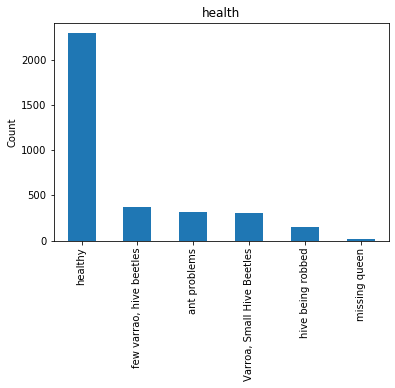

In [7]:
utils.value_counts(bees, 'health')

## 3.2 Ver imágenes

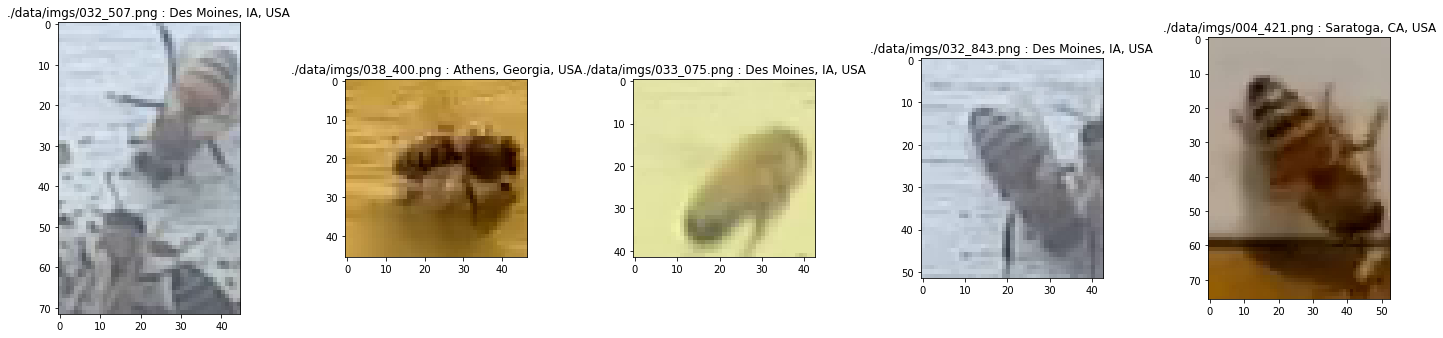

In [8]:
utils.plot_images(bees, 'location', [1, 25, 7, 100, 254])

# 4. Clasificación

## 4.1. Data preprocessing
### 4.1.1 Particionamiento

In [9]:
train_bees, val_bees, test_bees = utils.split(bees)


### 4.1.2 Carga de imágenes

In [10]:
# esta función ya uniformiza todas las imágenes en 100x100
train_X, val_X, test_X, train_y, val_y, test_y = utils.load_images_and_target(train_bees, 
                                                                              val_bees, 
                                                                              test_bees,
                                                                              'health',
                                                                              img_width, 
                                                                              img_height,
                                                                              img_channels)

In [11]:
train_bees['health']

225                      healthy
2453                     healthy
3009    few varrao, hive beetles
3270                     healthy
2622                     healthy
                  ...           
1275           hive being robbed
1439                     healthy
1175                ant problems
2765                     healthy
189                      healthy
Name: health, Length: 2338, dtype: category
Categories (6, object): [Varroa, Small Hive Beetles, ant problems, few varrao, hive beetles, healthy, hive being robbed, missing queen]

In [12]:
utils.categories['health']

array(['Varroa, Small Hive Beetles', 'ant problems',
       'few varrao, hive beetles', 'healthy', 'hive being robbed',
       'missing queen'], dtype=object)

In [13]:
utils.class_indices['health']

array([ 7,  8,  9, 10, 11, 12])

In [14]:
class_weights = utils.class_weights(bees, 'health')
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.9186046511627908,
 1: 1.8160377358490567,
 2: 1.5359042553191489,
 3: 0.2518534670737026,
 4: 3.725806451612903,
 5: 26.25}

## 4.2 CNN

In [15]:
optimizer = Adam(lr = 0.001)
loss = 'categorical_crossentropy'

In [16]:
train_y.columns.size

6

In [17]:
#base_model = VGG16(weights='imagenet', include_top=False)

#for layer in base_model.layers:
#layer.trainable = False

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, img_channels))
# Do not include the ImageNet classifier at the top.
    
# congelo las capas del VGG16
base_model.trainable = False

#for layer in base_model.layers[:]:
 #   layer.trainable = False

model_input = Input((img_height, img_width, img_channels))

x = base_model (model_input, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.1)(x)  # Regularize with dropout

#x = Flatten()(x)
y1 = Dense(train_y.columns.size, activation = 'softmax')(x)

model1 = Model(inputs=model_input, outputs=y1)


In [18]:
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [19]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [20]:
model1.compile(optimizer = optimizer, 
               loss = loss, 
               metrics = [utils.MacroAverageRecallMetric(num_classes = train_y.columns.size)])

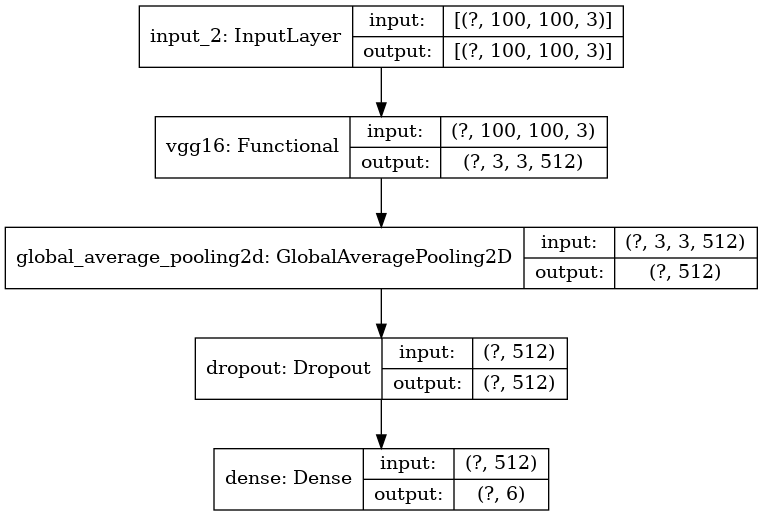

In [21]:
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
modelname = './models/' + model1.name + '_' + current_time
keras.utils.plot_model(model1, to_file = modelname + '.png', show_shapes = True)

## 4.3 Entrenamiento

### 4.2.2 Parámetros de transformación de imágenes (data augmentation)

In [22]:
rotation_range = 180     # rotación aleatoria en grados entre 0 a rotation_range
zoom_range = 0.1         # zoom aleatorio
width_shift_range = 0.1 # desplazamiento horizontal aleatorio (fracción del total)
height_shift_range = 0.1 # desplazamiento vertical aleatorio (fracción del total)
horizontal_flip = True   # transposición horizontal
vertical_flip = True     # transposición horizontal

In [23]:
batch_size = 10
epochs = 160
#defino un nuevo valor de steps_per_epoch así trabajo solo con batch_size
steps_per_epoch = train_X.shape[0] // batch_size
#steps_per_epoch = 30
patience = 10

In [24]:
earlystopper = EarlyStopping(monitor='val_loss', 
                             patience=patience, verbose=1,restore_best_weights=True)
callbacks = [earlystopper]

In [25]:
steps_per_epoch

233

In [26]:
train_X.shape

(2338, 100, 100, 3)

In [27]:
filepath = './checkpoints/' + model1.name + '_' + current_time + '_{epoch:02d}_{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor="val_loss", verbose=1, save_best_only=True)
callbacks.append(checkpoint)

In [28]:
bestepoch = utils.BestEpochCallback()
callbacks.append(bestepoch)

In [29]:
training1, model1 = utils.train(model1,
                                train_X, 
                                train_y, 
                                batch_size = batch_size,
                                epochs = epochs,
                                validation_data_X = val_X, 
                                validation_data_y = val_y,
                                steps_per_epoch = steps_per_epoch,
                                rotation_range = rotation_range,
                                zoom_range = zoom_range, 
                                width_shift_range = width_shift_range,
                                height_shift_range = height_shift_range,
                                horizontal_flip = horizontal_flip,  
                                vertical_flip = vertical_flip,
                                callbacks = callbacks,
                                class_weights = class_weights
                               )

Epoch 1/160
233/233 [==============================] - ETA: 0s - loss: 1.7426 - macro: 0.2987
Epoch 00001: val_loss improved from inf to 1.54803, saving model to ./checkpoints/functional_1_20201127_225150_01_1.55.h5
233/233 [==============================] - 13s 56ms/step - loss: 1.7426 - macro: 0.2987 - val_loss: 1.5480 - val_macro: 0.3036
Epoch 2/160
233/233 [==============================] - ETA: 0s - loss: 1.3804 - macro: 0.4020
Epoch 00002: val_loss improved from 1.54803 to 1.35885, saving model to ./checkpoints/functional_1_20201127_225150_02_1.36.h5
233/233 [==============================] - 13s 54ms/step - loss: 1.3804 - macro: 0.4020 - val_loss: 1.3589 - val_macro: 0.4113
Epoch 3/160
233/233 [==============================] - ETA: 0s - loss: 1.2005 - macro: 0.4686
Epoch 00003: val_loss improved from 1.35885 to 1.24020, saving model to ./checkpoints/functional_1_20201127_225150_03_1.24.h5
233/233 [==============================] - 13s 55ms/step - loss: 1.2005 - macro: 0.4686 - 

Epoch 27/160
232/233 [============================>.] - ETA: 0s - loss: 0.5957 - macro: 0.7178
Epoch 00027: val_loss did not improve from 0.60616
233/233 [==============================] - 13s 54ms/step - loss: 0.5946 - macro: 0.7178 - val_loss: 0.6912 - val_macro: 0.7182
Epoch 28/160
233/233 [==============================] - ETA: 0s - loss: 0.5667 - macro: 0.7209
Epoch 00028: val_loss did not improve from 0.60616
233/233 [==============================] - 13s 54ms/step - loss: 0.5667 - macro: 0.7209 - val_loss: 0.6743 - val_macro: 0.7213
Epoch 29/160
232/233 [============================>.] - ETA: 0s - loss: 0.5758 - macro: 0.7234
Epoch 00029: val_loss did not improve from 0.60616
233/233 [==============================] - 13s 54ms/step - loss: 0.5742 - macro: 0.7234 - val_loss: 0.6704 - val_macro: 0.7238
Epoch 30/160
232/233 [============================>.] - ETA: 0s - loss: 0.5935 - macro: 0.7255
Epoch 00030: val_loss did not improve from 0.60616
233/233 [==========================

Epoch 56/160
232/233 [============================>.] - ETA: 0s - loss: 0.5037 - macro: 0.7646
Epoch 00056: val_loss did not improve from 0.54101
233/233 [==============================] - 13s 54ms/step - loss: 0.5040 - macro: 0.7645 - val_loss: 0.5602 - val_macro: 0.7647
Epoch 57/160
233/233 [==============================] - ETA: 0s - loss: 0.5303 - macro: 0.7653
Epoch 00057: val_loss did not improve from 0.54101
233/233 [==============================] - 13s 55ms/step - loss: 0.5303 - macro: 0.7653 - val_loss: 0.6247 - val_macro: 0.7654
Epoch 58/160
233/233 [==============================] - ETA: 0s - loss: 0.4994 - macro: 0.7663Restoring model weights from the end of the best epoch.

Epoch 00058: val_loss did not improve from 0.54101
233/233 [==============================] - 13s 54ms/step - loss: 0.4994 - macro: 0.7663 - val_loss: 0.5823 - val_macro: 0.7663
Epoch 00058: early stopping
--- Early stopping best epoch    48 with loss 0.5410


## 4.3 Evaluación del modelo

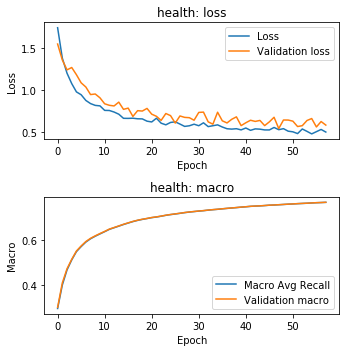

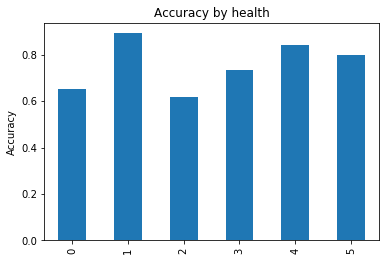

Classification report
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.56      0.70      0.62        69
              ant problems       0.88      0.92      0.90        84
  few varrao, hive beetles       0.49      0.73      0.58        81
                   healthy       0.97      0.80      0.88       584
         hive being robbed       0.58      0.93      0.71        44
             missing queen       0.24      1.00      0.38         5

                  accuracy                           0.81       867
                 macro avg       0.62      0.85      0.68       867
              weighted avg       0.86      0.81      0.82       867

Loss function: 0.5766732096672058


In [30]:
utils.eval_model(training1, model1, test_X, test_y, 'health')

In [31]:
trainedmodelname = modelname + '_{:02d}_{:.2f}.h5'.format(bestepoch.best_epoch, bestepoch.best_loss)
model1.save(trainedmodelname)

In [32]:
saved_model = keras.models.load_model(trainedmodelname, 
                                      custom_objects = {'MacroAverageRecallMetric' : utils.MacroAverageRecallMetric})

In [33]:
df_subspecies = utils.load_test_and_generate_prediction_file(model1, img_width, img_height, img_channels, 'subspecies')
df_subspecies

,id,expected
0,0,Russian honey bee
1,1,Italian honey bee
2,2,Carniolan honey bee
3,3,1 Mixed local stock 2
4,4,Carniolan honey bee
...,...,...
1702,1702,VSH Italian honey bee
1703,1703,Carniolan honey bee
1704,1704,1 Mixed local stock 2
1705,1705,Italian honey bee
